In [1]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# Thư viện để xử lý các text entry
import fuzzywuzzy
from fuzzywuzzy import process

from pandas.api.types import CategoricalDtype

# Thư viện xây dựng mô hình học máy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from sklearn.feature_selection import mutual_info_regression

# Thư viện dùng để ẩn các warnings
import warnings
warnings.filterwarnings('ignore')

d:\category_dtype_hanoi_saleprice\venv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
DATA_PATH = 'VN_housing_dataset.csv'

In [3]:
# Load dữ liệu và xem vài dòng đầu tiên của data.

df = pd.read_csv(DATA_PATH)
df.head()

,Unnamed: 0,Ngày,Địa chỉ,Quận,Huyện,Loại hình nhà ở,Giấy tờ pháp lý,Số tầng,Số phòng ngủ,Diện tích,Dài,Rộng,Giá/m2
0,0.0,2020-08-05,"Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...",Quận Cầu Giấy,Phường Nghĩa Đô,"Nhà ngõ, hẻm",Đã có sổ,4,5 phòng,46 m²,NaN,NaN,"86,96 triệu/m²"
1,1.0,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà mặt phố, mặt tiền",NaN,NaN,3 phòng,37 m²,NaN,NaN,"116,22 triệu/m²"
2,2.0,2020-08-05,"phố minh khai, Phường Minh Khai, Quận Hai Bà T...",Quận Hai Bà Trưng,Phường Minh Khai,"Nhà ngõ, hẻm",Đã có sổ,4,4 phòng,40 m²,10 m,4 m,65 triệu/m²
3,3.0,2020-08-05,"Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,...",Quận Tây Hồ,Phường Thụy Khuê,"Nhà ngõ, hẻm",Đã có sổ,NaN,6 phòng,51 m²,12.75 m,4 m,100 triệu/m²
4,4.0,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà ngõ, hẻm",NaN,NaN,4 phòng,36 m²,9 m,4 m,"86,11 triệu/m²"


In [4]:
# Xem thông tin của data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82497 entries, 0 to 82496
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       82496 non-null  float64
 1   Ngày             82496 non-null  object 
 2   Địa chỉ          82449 non-null  object 
 3   Quận             82495 non-null  object 
 4   Huyện            82449 non-null  object 
 5   Loại hình nhà ở  82465 non-null  object 
 6   Giấy tờ pháp lý  53610 non-null  object 
 7   Số tầng          36399 non-null  object 
 8   Số phòng ngủ     82458 non-null  object 
 9   Diện tích        82495 non-null  object 
 10  Dài              19827 non-null  object 
 11  Rộng             35445 non-null  object 
 12  Giá/m2           82484 non-null  object 
dtypes: float64(1), object(12)
memory usage: 8.2+ MB


# Data Cleaning

In [5]:
# Drop các dòng bị trùng

df.drop_duplicates(inplace=True)

In [6]:
# Số lượng các giá trị bị thiếu trong mỗi cột

df.isna().sum()

Unnamed: 0             1
Ngày                   1
Địa chỉ               48
Quận                   2
Huyện                 48
Loại hình nhà ở       32
Giấy tờ pháp lý    28887
Số tầng            46098
Số phòng ngủ          39
Diện tích              2
Dài                62670
Rộng               47052
Giá/m2                13
dtype: int64

In [7]:
# Tỉ lệ giá trị NaN trong mỗi cột

ratio_nan_per_col = df.isna().sum() / len(df) * 100
ratio_nan_per_col

Unnamed: 0          0.001212
Ngày                0.001212
Địa chỉ             0.058184
Quận                0.002424
Huyện               0.058184
Loại hình nhà ở     0.038789
Giấy tờ pháp lý    35.015819
Số tầng            55.878396
Số phòng ngủ        0.047274
Diện tích           0.002424
Dài                75.966399
Rộng               57.034801
Giá/m2              0.015758
dtype: float64

Có thể thấy các cột 'Unnamed: 0', 'Ngày', 'Địa chỉ', 'Quận (Huyện, Thị xã)', 'Huyện', 'Loại hình nhà ở', 'Giấy tờ pháp lý', 'Số phòng ngủ', 'Diện tích' và 'Giá/m2' có số lượng giá trị NaN > 0.1%, nên thay vì xử lý, ta sẽ drop nó luôn

In [8]:
print('Số lượng các dòng trước khi drop NaN:', len(df), 'dòng')

Số lượng các dòng trước khi drop NaN: 82497 dòng


In [9]:
for col, ratio in zip(ratio_nan_per_col.index, ratio_nan_per_col.values):
    if ratio < 1:
        df.dropna(subset=col, inplace=True)

In [10]:
print('Số lượng các dòng sau khi drop NaN:', len(df), 'dòng')

Số lượng các dòng sau khi drop NaN: 82360 dòng


## Convert cột "Ngày" sang datetime

In [11]:
df['Ngày'] = pd.to_datetime(df['Ngày'])

## Drop cột Unnamed: 0

In [12]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)


## Kiểm tra cột "Quận"

In [13]:
df['Quận'].unique()

array(['Quận Cầu Giấy', 'Quận Thanh Xuân', 'Quận Hai Bà Trưng',
       'Quận Tây Hồ', 'Quận Đống Đa', 'Quận Hà Đông', 'Huyện Thanh Trì',
       'Quận Hoàng Mai', 'Quận Long Biên', 'Quận Hoàn Kiếm',
       'Quận Nam Từ Liêm', 'Quận Ba Đình', 'Huyện Hoài Đức',
       'Quận Bắc Từ Liêm', 'Huyện Đan Phượng', 'Huyện Thanh Oai',
       'Huyện Sóc Sơn', 'Huyện Gia Lâm', 'Huyện Chương Mỹ',
       'Huyện Đông Anh', 'Huyện Thường Tín', 'Thị xã Sơn Tây',
       'Huyện Mê Linh', 'Huyện Thạch Thất', 'Huyện Quốc Oai',
       'Huyện Phúc Thọ', 'Huyện Phú Xuyên', 'Huyện Ba Vì', 'Huyện Mỹ Đức'],
      dtype=object)

***Normial category***

Chuyển data-type của 'Quận (Huyện, Thị xã)' sang 'category'.

Nếu các giá trị của 1 cột là hữu hạn, ta nên đưa nó về category, nó sẽ giúp tiết kiệm bộ nhớ, cũng như có thể sử dụng các phương thức khác, mà kiểu object không thể, mặc dù cả hai đều chứa string.<br>
Trong trường hợp, cột đó chứa feedback, hoặc description của sản phẩm, thì ta sẽ để nó ở kiểu object.

In [14]:
before = df['Quận'].memory_usage()  # memory usage of column in bytes
print(f'Trước khi chuyển sang categoy: {before * 1e-3} kb')

Trước khi chuyển sang categoy: 1317.76 kb


In [15]:
df['Quận'] = df['Quận'].astype('category')

after = df['Quận'].memory_usage()
print(f'Sau khi chuyển sang category: {after * 1e-3} kb')

result = (before - after) / before
print(f'Giảm tới: {round(result * 100, 2)}%')

Sau khi chuyển sang category: 742.544 kb
Giảm tới: 43.65%


Sau khi chuyển kiểu dữ liệu sang category, ta có thể encode, sắp xếp hoặc so sánh (nếu như đó là ordinal category).

In [16]:
df['Quận'].cat.categories

Index(['Huyện Ba Vì', 'Huyện Chương Mỹ', 'Huyện Gia Lâm', 'Huyện Hoài Đức',
       'Huyện Mê Linh', 'Huyện Mỹ Đức', 'Huyện Phú Xuyên', 'Huyện Phúc Thọ',
       'Huyện Quốc Oai', 'Huyện Sóc Sơn', 'Huyện Thanh Oai', 'Huyện Thanh Trì',
       'Huyện Thường Tín', 'Huyện Thạch Thất', 'Huyện Đan Phượng',
       'Huyện Đông Anh', 'Quận Ba Đình', 'Quận Bắc Từ Liêm', 'Quận Cầu Giấy',
       'Quận Hai Bà Trưng', 'Quận Hoàn Kiếm', 'Quận Hoàng Mai', 'Quận Hà Đông',
       'Quận Long Biên', 'Quận Nam Từ Liêm', 'Quận Thanh Xuân', 'Quận Tây Hồ',
       'Quận Đống Đa', 'Thị xã Sơn Tây'],
      dtype='object')

In [17]:
df['Quận'].head()

0        Quận Cầu Giấy
1      Quận Thanh Xuân
2    Quận Hai Bà Trưng
3          Quận Tây Hồ
4      Quận Thanh Xuân
Name: Quận, dtype: category
Categories (29, object): ['Huyện Ba Vì', 'Huyện Chương Mỹ', 'Huyện Gia Lâm', 'Huyện Hoài Đức', ..., 'Quận Thanh Xuân', 'Quận Tây Hồ', 'Quận Đống Đa', 'Thị xã Sơn Tây']

In [18]:
df['Quận'].cat.codes[:5]

0    18
1    25
2    19
3    26
4    25
dtype: int8

## Kiểm tra cột "Giấy tờ pháp lý"

***Ordinal Category***

Việc chuyển sang Ordinal Category cũng giống như Norminal Category, nhưng ta sẽ thêm vào đó order của các giá trị.<br>
Ví dụ, 'thấp' < 'trung bình' < 'cao'

In [19]:
df['Giấy tờ pháp lý'].fillna('Unknown', inplace=True)

In [20]:
df['Giấy tờ pháp lý'].unique()

array(['Đã có sổ', 'Unknown', 'Đang chờ sổ', 'Giấy tờ khác'], dtype=object)

Ở đây ta có 'Đã có sổ', nan, 'Đang chờ sổ', 'Giấy tờ khác', vậy ta có thể tưởng tượng trong đầu ra thứ tự của nó.<br>

'Unknown < 'Giấy tờ khác' < 'Đang chờ sổ' < 'Đã có sổ'

#### Trước khi chuyển sang ordinal category

In [21]:
df[df['Giấy tờ pháp lý'] > 'Giấy tờ khác']['Giấy tờ pháp lý'].unique()

array(['Đã có sổ', 'Unknown', 'Đang chờ sổ'], dtype=object)

#### Sau khi chuyển sang ordinal category

In [22]:
giay_to_phap_ly = ['Unknown', 'Giấy tờ khác', 'Đang chờ sổ', 'Đã có sổ']
df['Giấy tờ pháp lý'] = df['Giấy tờ pháp lý'].astype(CategoricalDtype(categories=giay_to_phap_ly, ordered=True))

In [23]:
df[df['Giấy tờ pháp lý'] > 'Giấy tờ khác']['Giấy tờ pháp lý'].unique()

['Đã có sổ', 'Đang chờ sổ']
Categories (4, object): ['Unknown' < 'Giấy tờ khác' < 'Đang chờ sổ' < 'Đã có sổ']

*Note*: Có thể thấy, khi lọc các entries ở cột "Giấy tờ pháp lý" có giá trị cao hơn "Giấy tờ khác", sẽ trả về các entries có giá trị là "Đã có sổ" và "Đang chờ sổ" đúng như order ta mong muốn.

In [24]:
df['Giấy tờ pháp lý'].head()

0    Đã có sổ
1     Unknown
2    Đã có sổ
3    Đã có sổ
4     Unknown
Name: Giấy tờ pháp lý, dtype: category
Categories (4, object): ['Unknown' < 'Giấy tờ khác' < 'Đang chờ sổ' < 'Đã có sổ']

## Kiểm tra cột "Loại hình nhà ở"

In [25]:
df['Loại hình nhà ở'].unique()

array(['Nhà ngõ, hẻm', 'Nhà mặt phố, mặt tiền', 'Nhà biệt thự',
       'Nhà phố liền kề'], dtype=object)

In [26]:
loai_hinh_nha_o = ['Nhà ngõ, hẻm', 'Nhà mặt phố, mặt tiền', 'Nhà phố liền kề', 'Nhà biệt thự']
df['Loại hình nhà ở'] = df['Loại hình nhà ở'].astype(CategoricalDtype(categories=loai_hinh_nha_o, ordered=True))

In [27]:
df['Loại hình nhà ở'].head()

0             Nhà ngõ, hẻm
1    Nhà mặt phố, mặt tiền
2             Nhà ngõ, hẻm
3             Nhà ngõ, hẻm
4             Nhà ngõ, hẻm
Name: Loại hình nhà ở, dtype: category
Categories (4, object): ['Nhà ngõ, hẻm' < 'Nhà mặt phố, mặt tiền' < 'Nhà phố liền kề' < 'Nhà biệt thự']

## Kiểm tra cột "Huyện"

Đổi tên 'Huyện' sang 'Phường'

In [28]:
df.rename(columns={'Huyện': 'Phường'}, inplace=True)

In [29]:
df['Phường'].unique()

array(['Phường Nghĩa Đô', 'Phường Kim Giang', 'Phường Minh Khai',
       'Phường Thụy Khuê', 'Phường Yên Hoà', 'Phường Trung Liệt',
       'Phường Đống Mác', 'Phường Xuân La', 'Phường Văn Quán',
       'Thị trấn Văn Điển', 'Phường Định Công', 'Phường Bồ Đề',
       'Phường Quang Trung', 'Phường Thanh Lương', 'Phường Khương Trung',
       'Phường Phúc Tân', 'Phường Gia Thụy', 'Phường Khương Đình',
       'Phường Phương Canh', 'Phường Tương Mai', 'Phường La Khê',
       'Phường Mễ Trì', 'Phường Khương Mai', 'Phường Láng Hạ',
       'Phường Quan Hoa', 'Phường Tây Mỗ', 'Phường Ngọc Khánh',
       'Phường Đại Mỗ', 'Xã Tả Thanh Oai', 'Phường Mỹ Đình 1',
       'Xã Tam Hiệp', 'Phường Cống Vị', 'Phường Bách Khoa',
       'Phường Vĩnh Phúc', 'Xã Kim Chung', 'Phường Đại Kim',
       'Phường Mai Động', 'Phường Trung Tự', 'Phường Kiến Hưng',
       'Phường Trúc Bạch', 'Phường Cổ Nhuế 1', 'Phường Đức Giang',
       'Phường Mỹ Đình 2', 'Phường Bưởi', 'Phường Ô Chợ Dừa',
       'Phường Long Biên', 'P

Sử dụng thư viện fuzzywuzzy để xử lý các chuỗi khớp nhau

In [30]:
phuong_unique = df['Phường'].unique()

In [31]:
matches = fuzzywuzzy.process.extract('Phường Nghĩa Đô', phuong_unique, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
matches

[('Phường Nghĩa Đô', 100),
 ('Phường Nghĩa Tân', 90),
 ('Phường Yên Nghĩa', 90),
 ('Phường Hàng Đào', 81),
 ('Phường Phú Đô', 80),
 ('Phường Định Công', 76),
 ('Phường Nam Đồng', 76),
 ('Phường Đông Ngạc', 76),
 ('Phường Đồng Nhân', 76),
 ('Phường Hạ Đình', 74)]

In [32]:
def replace_matches_in_column(df, column, string_to_match, min_ratio):
    strings = df[column].unique()
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match

In [33]:
for phuong in phuong_unique:
    replace_matches_in_column(df=df, column='Phường', string_to_match=phuong, min_ratio=99)

print('Done!')

Done!


Đưa cột 'Huyện' về kiểu normial category

In [34]:
df['Phường'] = df['Phường'].astype('category')

## Kiểm tra cột "Số tầng"

In [35]:
df['Số tầng'].unique()

array(['4', nan, '6', '5', '7', '2', '3', '8', '1', '9', '50', '38', '35',
       '10', 'Nhiều hơn 10', '45', '33', '42', '25', '73', '12', '65',
       '55', '30', '14', '40', '52', '54', '32', '29'], dtype=object)

In [36]:
df['Số tầng'].fillna('Unknown', inplace=True)

In [37]:
df['Số tầng'].value_counts()

Số tầng
Unknown         45971
5               15764
4               12275
3                3618
6                2119
2                1028
1                 636
7                 597
8                 188
9                  88
10                 36
45                  8
Nhiều hơn 10        7
35                  6
50                  2
12                  2
38                  2
30                  1
32                  1
54                  1
52                  1
40                  1
14                  1
65                  1
55                  1
73                  1
25                  1
42                  1
33                  1
29                  1
Name: count, dtype: int64

Số lượng các nhà có tầng nhiều hơn 10 nhỏ, do vậy ta có thể đưa chúng về '>10'

In [38]:
def process_so_tang(x):
    try:
        if x == 'Nhiều hơn 10' or int(x) > 10:
            return '>10'
        return x
    except:
        return x

In [39]:
df['Số tầng'] = df['Số tầng'].apply(process_so_tang)

In [40]:
df['Số tầng'].value_counts()

Số tầng
Unknown    45971
5          15764
4          12275
3           3618
6           2119
2           1028
1            636
7            597
8            188
9             88
>10           40
10            36
Name: count, dtype: int64

Đưa cột 'Số tầng' về kiểu ordinal category

In [41]:
so_tang = ['Unknown', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '>10']
df['Số tầng'] = df['Số tầng'].astype(CategoricalDtype(categories=so_tang, ordered=True))

In [42]:
df['Số tầng'].head()

0          4
1    Unknown
2          4
3    Unknown
4    Unknown
Name: Số tầng, dtype: category
Categories (12, object): ['Unknown' < '1' < '2' < '3' ... '8' < '9' < '10' < '>10']

## Kiểm tra cột "Số phòng ngủ"

In [43]:
df['Số phòng ngủ'].unique()

array(['5 phòng', '3 phòng', '4 phòng', '6 phòng', 'nhiều hơn 10 phòng',
       '8 phòng', '2 phòng', '7 phòng', '9 phòng', '1 phòng', '10 phòng'],
      dtype=object)

Replace 'nhiều hơn 10 phòng' thành '>10'

In [44]:
df['Số phòng ngủ'].replace('nhiều hơn 10 phòng', '>10', inplace=True)

In [45]:

so_phong_ngu = ['1 phòng', '2 phòng', '3 phòng', '4 phòng', '5 phòng', '6 phòng', '7 phòng', '8 phòng', '9 phòng', '10 phòng', '>10']
df['Số phòng ngủ'] = df['Số phòng ngủ'].astype(CategoricalDtype(categories=so_phong_ngu, ordered=True))

In [46]:
df['Số phòng ngủ'].head()

0    5 phòng
1    3 phòng
2    4 phòng
3    6 phòng
4    4 phòng
Name: Số phòng ngủ, dtype: category
Categories (11, object): ['1 phòng' < '2 phòng' < '3 phòng' < '4 phòng' ... '8 phòng' < '9 phòng' < '10 phòng' < '>10']

## Kiểm tra cột "Diện tích"

In [47]:
df['Diện tích'].unique()

array(['46 m²', '37 m²', '40 m²', '51 m²', '36 m²', '52 m²', '32 m²',
       '75 m²', '41 m²', '35 m²', '30 m²', '50 m²', '52.8 m²', '165 m²',
       '70 m²', '34 m²', '65 m²', '45 m²', '79 m²', '90 m²', '73 m²',
       '18 m²', '42 m²', '43 m²', '25 m²', '38 m²', '49 m²', '33 m²',
       '120 m²', '200 m²', '47 m²', '55 m²', '77 m²', '27 m²', '60 m²',
       '81 m²', '20 m²', '54 m²', '28 m²', '113 m²', '76 m²', '62 m²',
       '11 m²', '44 m²', '21 m²', '58 m²', '196 m²', '48 m²', '24 m²',
       '56 m²', '104 m²', '83 m²', '68 m²', '31 m²', '64 m²', '32.1 m²',
       '185 m²', '61 m²', '23 m²', '92 m²', '85 m²', '30.2 m²', '26 m²',
       '140 m²', '31.5 m²', '63 m²', '39 m²', '80 m²', '57 m²', '16 m²',
       '13 m²', '67 m²', '35.22 m²', '110 m²', '35.21 m²', '138 m²',
       '3 m²', '40.22 m²', '22 m²', '32.22 m²', '82 m²', '53 m²', '86 m²',
       '47.3 m²', '33.33 m²', '87 m²', '96 m²', '66 m²', '451 m²',
       '108 m²', '32.07 m²', '125 m²', '33.1 m²', '39.8 m²', '36.5 m²',
 

Đưa cột 'Diện tích' về kiểu numerial

In [48]:
df['Diện tích'] = df['Diện tích'].apply(lambda x: x.replace('m²', '').replace(',', '.')).astype(float)

In [49]:
df['Diện tích'].dtypes

dtype('float64')

## Xử lý cột "Dài" và "Rộng"

In [50]:
df['Dài'].fillna('0', inplace=True)
df['Rộng'].fillna('0', inplace=True)

Đưa cột "Dài" và "Rộng" về kiểu numerial

In [51]:
df['Dài'] = df['Dài'].apply(lambda x: x.replace('m', '').replace(',', '.')).astype(float)
df['Rộng'] = df['Rộng'].apply(lambda x: x.replace('m', '').replace(',', '.')).astype(float)

Các giá trị trống cột "Dài" nhưng có giá trị cột "Rộng"

In [52]:
df_missing_dai = df[(df['Dài'] == 0) & (df['Rộng'] != 0)]
df_missing_dai

,Ngày,Địa chỉ,Quận,Phường,Loại hình nhà ở,Giấy tờ pháp lý,Số tầng,Số phòng ngủ,Diện tích,Dài,Rộng,Giá/m2
6,2020-08-05,"Đường Tây Sơn, Phường Trung Liệt, Quận Đống Đa...",Quận Đống Đa,Phường Trung Liệt,"Nhà ngõ, hẻm",Unknown,Unknown,3 phòng,52.0,0.0,4.5,"112,5 triệu/m²"
7,2020-08-05,"Đường Lò Đúc, Phường Đống Mác, Quận Hai Bà Trư...",Quận Hai Bà Trưng,Phường Đống Mác,"Nhà mặt phố, mặt tiền",Đã có sổ,6,5 phòng,32.0,0.0,6.8,"184,38 triệu/m²"
9,2020-08-05,"Đường 19/5, Phường Văn Quán, Quận Hà Đông, Hà Nội",Quận Hà Đông,Phường Văn Quán,"Nhà ngõ, hẻm",Đã có sổ,4,3 phòng,41.0,0.0,3.5,"64,63 triệu/m²"
13,2020-08-05,"Đường Quang Trung, Phường Quang Trung, Quận Hà...",Quận Hà Đông,Phường Quang Trung,"Nhà ngõ, hẻm",Unknown,Unknown,5 phòng,50.0,0.0,5.0,86 triệu/m²
17,2020-08-05,"Đường Phúc Tân, Phường Phúc Tân, Quận Hoàn Kiế...",Quận Hoàn Kiếm,Phường Phúc Tân,"Nhà mặt phố, mặt tiền",Đã có sổ,7,>10,165.0,0.0,5.0,"103,03 triệu/m²"
...,...,...,...,...,...,...,...,...,...,...,...,...
82342,2020-04-27,"Đường Chợ Khâm Thiên, Phường Trung Phụng, Quận...",Quận Đống Đa,Phường Trung Phụng,"Nhà ngõ, hẻm",Đã có sổ,3,2 phòng,22.0,0.0,2.5,"63,64 triệu/m²"
82345,2020-04-25,"285, Đường Đội Cấn, Phường Đội Cấn, Quận Ba Đì...",Quận Ba Đình,Phường Đội Cấn,"Nhà ngõ, hẻm",Đã có sổ,5,3 phòng,41.0,0.0,3.0,"75,61 triệu/m²"
82347,2020-04-24,"Đường Hoàng Hoa Thám, Phường Ngọc Hà, Quận Ba ...",Quận Ba Đình,Phường Ngọc Hà,Nhà biệt thự,Đã có sổ,4,5 phòng,230.0,0.0,8.0,"117,39 triệu/m²"
82357,2020-04-17,"Đường Đội Cấn, Phường Đội Cấn, Quận Ba Đình, H...",Quận Ba Đình,Phường Đội Cấn,"Nhà ngõ, hẻm",Đã có sổ,6,2 phòng,20.0,0.0,4.0,85 triệu/m²


In [53]:
df_missing_dai['Dài'] = df_missing_dai['Diện tích'] / df_missing_dai['Rộng']

Các giá trị trống cột "Rộng" nhưng có giá trị cột "Dài"

In [54]:
df_missing_rong = df[(df['Dài'] != 0) & (df['Rộng'] == 0)]
df_missing_rong

,Ngày,Địa chỉ,Quận,Phường,Loại hình nhà ở,Giấy tờ pháp lý,Số tầng,Số phòng ngủ,Diện tích,Dài,Rộng,Giá/m2
221,2020-08-04,"Đường Hoàng Hoa Thám, Phường Đội Cấn, Quận Ba ...",Quận Ba Đình,Phường Đội Cấn,"Nhà ngõ, hẻm",Đã có sổ,5,5 phòng,61.0,4.6,0.0,"116,39 triệu/m²"
536,2020-08-04,"Đường Khương Đình||655, Phường Khương Đình, Qu...",Quận Thanh Xuân,Phường Khương Đình,"Nhà ngõ, hẻm",Đã có sổ,5,3 phòng,26.0,7.0,0.0,"101,92 triệu/m²"
636,2020-08-04,"Đường Lê Trọng Tấn, Phường Khương Mai, Quận Th...",Quận Thanh Xuân,Phường Khương Mai,"Nhà ngõ, hẻm",Unknown,Unknown,4 phòng,48.0,48.0,0.0,"106,25 triệu/m²"
823,2020-08-04,"Ao Sen, Phường Mộ Lao, Quận Hà Đông, Hà Nội",Quận Hà Đông,Phường Mộ Lao,"Nhà ngõ, hẻm",Đã có sổ,4,4 phòng,45.0,12.0,0.0,"111,11 triệu/m²"
1403,2020-08-04,"Đường Lạc Long Quân, Phường Bưởi, Quận Tây Hồ,...",Quận Tây Hồ,Phường Bưởi,"Nhà ngõ, hẻm",Đã có sổ,5,6 phòng,95.0,5.0,0.0,"110,53 triệu/m²"
...,...,...,...,...,...,...,...,...,...,...,...,...
80887,2020-06-07,"Đường Nguyễn Văn Cừ, Phường Bồ Đề, Quận Long B...",Quận Long Biên,Phường Bồ Đề,"Nhà ngõ, hẻm",Đã có sổ,Unknown,4 phòng,65.0,6.0,0.0,"54,62 triệu/m²"
81721,2020-06-06,"Đường Cự Lộc, Phường Thượng Đình, Quận Thanh X...",Quận Thanh Xuân,Phường Thượng Đình,"Nhà ngõ, hẻm",Đã có sổ,4,3 phòng,45.0,4.0,0.0,70 triệu/m²
82101,2020-06-05,"Đường Láng Hạ||386, Phường Láng Hạ, Quận Đống ...",Quận Đống Đa,Phường Láng Hạ,Nhà biệt thự,Đã có sổ,4,4 phòng,71.0,7.0,0.0,"133,8 triệu/m²"
82165,2020-05-27,"Đường Trường Chinh, Phường Thượng Đình, Quận T...",Quận Thanh Xuân,Phường Thượng Đình,"Nhà mặt phố, mặt tiền",Đã có sổ,4,5 phòng,76.0,3.4,0.0,"315,79 triệu/m²"


In [55]:
df_missing_rong['Rộng'] = df_missing_rong['Diện tích'] / df_missing_rong['Dài']

In [56]:
print('Số dòng bị thiếu giá trị Dài:', len(df[df['Dài'] == 0]), 'dòng')

Số dòng bị thiếu giá trị Dài: 62553 dòng


In [57]:
df.loc[df_missing_dai.index, 'Dài'] = df_missing_dai['Dài']

In [58]:
print('Số dòng bị thiếu giá trị Dài sau khi xử lý: ', len(df[df['Dài'] == 0]), 'dòng')

Số dòng bị thiếu giá trị Dài sau khi xử lý:  46820 dòng


In [59]:
df.loc[df_missing_rong.index, 'Rộng'] = df_missing_rong['Rộng']

## Xử lý cột "Giá/m2"

In [60]:
df['Giá/m2'].value_counts()

Giá/m2
100 triệu/m²         2500
80 triệu/m²          1154
75 triệu/m²           962
90 triệu/m²           838
83,33 triệu/m²        810
                     ... 
36,78 triệu/m²          1
30,95 triệu/m²          1
1,688888888 tỷ/m²       1
114,33 triệu/m²         1
341,46 triệu/m²         1
Name: count, Length: 8328, dtype: int64

Các đơn vị tính trong cột "Giá"

In [61]:
don_vi_gia = df['Giá/m2'].apply(lambda x: x.split(' ')[1])
don_vi_gia.value_counts()

Giá/m2
triệu/m²    81516
đ/m²          727
tỷ/m²         117
Name: count, dtype: int64

In [62]:
df[don_vi_gia == 'đ/m²']

,Ngày,Địa chỉ,Quận,Phường,Loại hình nhà ở,Giấy tờ pháp lý,Số tầng,Số phòng ngủ,Diện tích,Dài,Rộng,Giá/m2
93,2020-08-04,"Đường Hàm Nghi, Phường Cầu Diễn, Quận Nam Từ L...",Quận Nam Từ Liêm,Phường Cầu Diễn,Nhà phố liền kề,Đã có sổ,5,4 phòng,113.0,14.125,8.0,247.787 đ/m²
283,2020-08-04,"Chùa Bộc, Phường Kim Liên, Quận Đống Đa, Hà Nội",Quận Đống Đa,Phường Kim Liên,"Nhà ngõ, hẻm",Unknown,Unknown,3 phòng,42.0,0.000,0.0,90.476 đ/m²
338,2020-08-04,"Ngõ 405, Đường Ngọc Thụy, Phường Ngọc Thụy, Qu...",Quận Long Biên,Phường Ngọc Thụy,"Nhà ngõ, hẻm",Đã có sổ,Unknown,3 phòng,140.0,21.000,6.8,178.571 đ/m²
351,2020-08-04,"Nguyễn Chính, Phường Tân Mai, Quận Hoàng Mai, ...",Quận Hoàng Mai,Phường Tân Mai,"Nhà mặt phố, mặt tiền",Đã có sổ,5,6 phòng,60.0,15.000,4.0,125.000 đ/m²
621,2020-08-04,"Đường Nguyễn An Ninh, Phường Đồng Tâm, Quận Ha...",Quận Hai Bà Trưng,Phường Đồng Tâm,"Nhà ngõ, hẻm",Đã có sổ,3,2 phòng,53.0,0.000,0.0,75.471 đ/m²
...,...,...,...,...,...,...,...,...,...,...,...,...
82294,2020-05-10,"Đường Xuân Đỉnh, Phường Xuân La, Quận Tây Hồ, ...",Quận Tây Hồ,Phường Xuân La,"Nhà ngõ, hẻm",Đã có sổ,6,5 phòng,49.0,0.000,0.0,59.183 đ/m²
82316,2020-05-07,"Đường Láng, Phường Láng Thượng, Quận Đống Đa, ...",Quận Đống Đa,Phường Láng Thượng,"Nhà ngõ, hẻm",Đã có sổ,Unknown,4 phòng,45.0,11.250,4.0,85.555 đ/m²
82325,2020-05-04,"Đường Hào Nam, Phường Ô Chợ Dừa, Quận Đống Đa,...",Quận Đống Đa,Phường Ô Chợ Dừa,"Nhà ngõ, hẻm",Đã có sổ,Unknown,4 phòng,38.0,0.000,0.0,86.842 đ/m²
82344,2020-04-27,"Đường Hoàng Mai, Phường Hoàng Văn Thụ, Quận Ho...",Quận Hoàng Mai,Phường Hoàng Văn Thụ,"Nhà ngõ, hẻm",Unknown,Unknown,3 phòng,46.0,0.000,0.0,69.565 đ/m²


Có thể đ/m² chính là triệu/m²

In [63]:
df[don_vi_gia == 'tỷ/m²']

,Ngày,Địa chỉ,Quận,Phường,Loại hình nhà ở,Giấy tờ pháp lý,Số tầng,Số phòng ngủ,Diện tích,Dài,Rộng,Giá/m2
1100,2020-08-04,"Đường Trường Chinh, Phường Khương Trung, Quận ...",Quận Thanh Xuân,Phường Khương Trung,"Nhà ngõ, hẻm",Unknown,Unknown,3 phòng,36.00,0.000000,0.0,"1,202777777 tỷ/m²"
1144,2020-08-04,"Đường Láng Hạ, Phường Láng Hạ, Quận Đống Đa, H...",Quận Đống Đa,Phường Láng Hạ,"Nhà ngõ, hẻm",Đã có sổ,5,3 phòng,35.00,0.000000,0.0,"1,142857142 tỷ/m²"
1657,2020-08-04,"Đường Văn Khê, Phường La Khê, Quận Hà Đông, Hà...",Quận Hà Đông,Phường La Khê,Nhà phố liền kề,Unknown,Unknown,6 phòng,5.00,0.000000,0.0,"1,96 tỷ/m²"
2849,2020-08-03,"Đường Vũ Trọng Phụng||702, Phường Thanh Xuân T...",Quận Thanh Xuân,Phường Thanh Xuân Trung,"Nhà ngõ, hẻm",Unknown,Unknown,2 phòng,35.00,0.000000,0.0,"1,557142857 tỷ/m²"
2939,2020-08-03,"Đường Minh Khai, Phường Minh Khai, Quận Hai Bà...",Quận Hai Bà Trưng,Phường Minh Khai,"Nhà ngõ, hẻm",Đã có sổ,Unknown,5 phòng,3.99,0.000000,0.0,"1,316666666 tỷ/m²"
...,...,...,...,...,...,...,...,...,...,...,...,...
78107,2020-06-09,"Đường Lê Trọng Tấn, Xã Vân Canh, Huyện Hoài Đứ...",Huyện Hoài Đức,Xã Vân Canh,"Nhà ngõ, hẻm",Đã có sổ,4,3 phòng,30.00,0.000000,0.0,"5,833333333 tỷ/m²"
79034,2020-06-09,"Đường Láng, Phường Láng Thượng, Quận Đống Đa, ...",Quận Đống Đa,Phường Láng Thượng,"Nhà ngõ, hẻm",Đã có sổ,4,4 phòng,40.00,13.333333,3.0,"1,0125 tỷ/m²"
79835,2020-06-08,"Đường Chùa Bộc, Phường Nam Đồng, Quận Đống Đa,...",Quận Đống Đa,Phường Nam Đồng,"Nhà ngõ, hẻm",Đã có sổ,Unknown,3 phòng,45.00,11.000000,4.0,"1,706666666 tỷ/m²"
80222,2020-06-08,"Đường Đinh Tiên Hoàng, Phường Lý Thái Tổ, Quận...",Quận Hoàn Kiếm,Phường Lý Thái Tổ,"Nhà mặt phố, mặt tiền",Unknown,Unknown,4 phòng,100.00,0.000000,0.0,"1,5 tỷ/m²"


Ta sẽ xử lý bằng cách thêm cột "Đơn vị tính", và bỏ đơn vị trong cột "Giá/m2", đưa các giá trị trong cột "Giá/m2" về numerical

In [64]:
df['Đơn vị tính'] = df['Giá/m2'].apply(lambda x: x.split(' ')[1])
df['Giá/m2'] = df['Giá/m2'].apply(lambda x: x.split(' ')[0])

Trong cột 'Giá/m2' có các giá trị không thể chuyển sang float

In [65]:
def extract_idx_value(pd_series):
    idx = pd_series.index
    value = pd_series.values
    return idx, value

In [66]:
idx, values = extract_idx_value(df['Giá/m2'].apply(lambda x: x.replace(',', '.')))

for _idx, value in zip(idx, values):
    try:
        float(value)
    except:
        print(_idx, value)

52317 2.222.22220022
55653 728.000.00728


In [67]:
df.drop([52317, 55653], inplace=True)
df['Giá/m2'] = df['Giá/m2'].apply(lambda x: x.replace(',', '.')).astype(float)

# Feature Engineering

Tạo feature 'Giá' bằng 'Giá/m2' * 'Diện tích' với đơn vị là tỷ.
Các entries có 'Đơn vị tính' là 'triệu/m²' sẽ chia cho 1000

In [68]:
for row, col in df.iterrows():
    df.loc[row, 'Giá'] = col['Giá/m2'] * col['Diện tích']
    if col['Đơn vị tính'] != 'tỷ/m²':
        df.loc[row, 'Giá'] /= 1000

Tạo feature 'Nội thành'

In [69]:
df['Nội thành'] = df['Quận'].apply(lambda x: True if 'Quận' in x else False)

Tạo feature 'Năm'

In [70]:
df['Năm'] = df['Ngày'].dt.year

In [71]:
df['Năm'] = df['Năm'].astype(CategoricalDtype(categories=[2019, 2020], ordered=True))

# EDA

In [72]:
print('Giá nhà cao nhất:', df['Giá'].max(), 'tỷ')
print('Giá nhà thấp nhất:', df['Giá'].min(), 'tỷ')

Giá nhà cao nhất: 7888.79999999 tỷ
Giá nhà thấp nhất: 0.026 tỷ


Giá nhà cao nhất có giá 7888 tỷ đồng, thấp nhất có giá 26 triệu đồng

<Figure size 800x600 with 0 Axes>

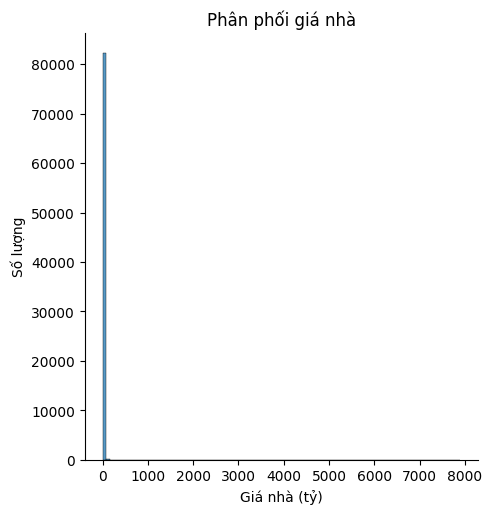

In [73]:
plt.figure(figsize=(8, 6))
sns.displot(data=df, x='Giá', bins=100, kde=False)
plt.title('Phân phối giá nhà')
plt.xlabel('Giá nhà (tỷ)')
plt.ylabel('Số lượng')
plt.show()

In [74]:
print('Skew before drop outlier:', df['Giá'].skew())

Skew before drop outlier: 76.53379479223594


Drop các outliner > 0.99 và < 0.01

In [75]:
q_low = df['Giá'].quantile(0.01)
q_hi  = df['Giá'].quantile(0.99)

df_drop_outlier = df[(df['Giá'] < q_hi) & (df['Giá'] > q_low)]

<Figure size 800x600 with 0 Axes>

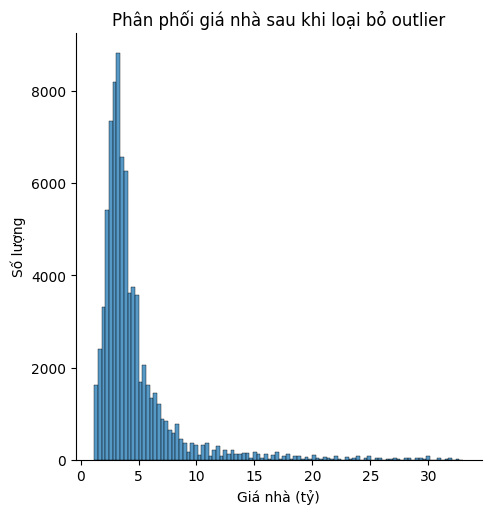

In [76]:
plt.figure(figsize=(8, 6))
sns.displot(data=df_drop_outlier, x='Giá', kde=False, bins=100)
plt.title('Phân phối giá nhà sau khi loại bỏ outlier')
plt.xlabel('Giá nhà (tỷ)')
plt.ylabel('Số lượng')
plt.show()

In [77]:
print('Skew after drop outlier:', df_drop_outlier['Giá'].skew())

Skew after drop outlier: 3.5263391712111307


In [78]:
print('Giá nhà cao nhất:', df_drop_outlier['Giá'].max(), 'tỷ')
print('Giá nhà thấp nhất:', df_drop_outlier['Giá'].min(), 'tỷ')

Giá nhà cao nhất: 32.9994 tỷ
Giá nhà thấp nhất: 1.1900899999999999 tỷ


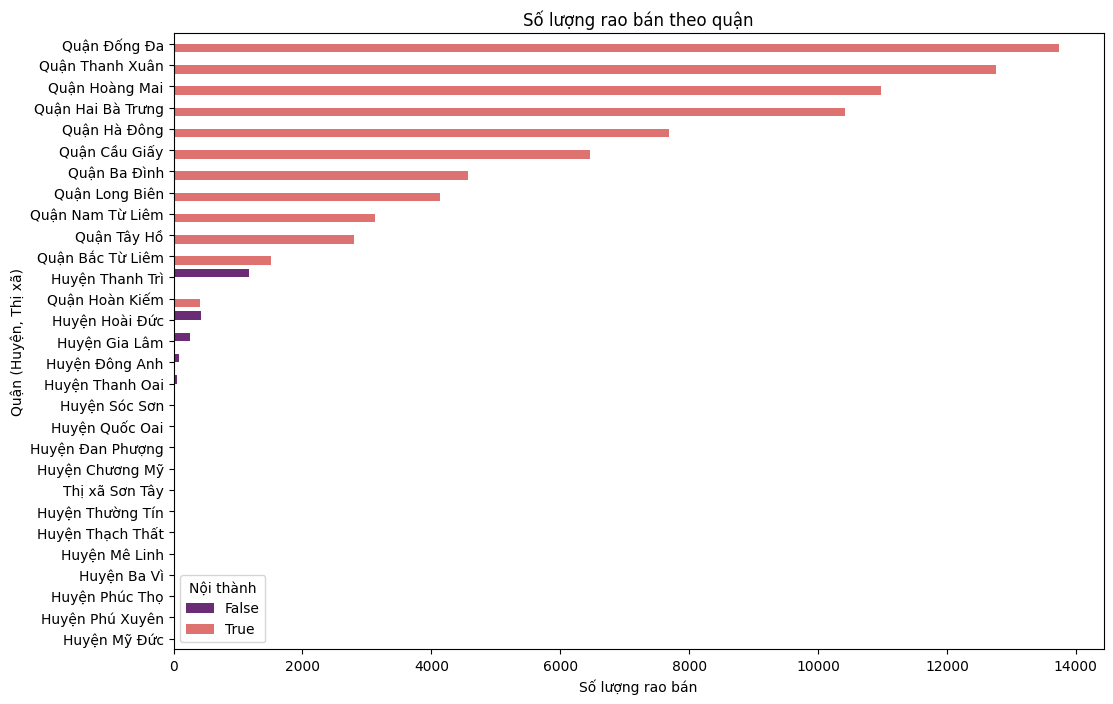

In [79]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df_drop_outlier, y='Quận', hue='Nội thành', order=df['Quận'].value_counts().index, palette='magma')
plt.title('Số lượng rao bán theo quận')
plt.xlabel('Số lượng rao bán')
plt.ylabel('Quận (Huyện, Thị xã)')
plt.show()

In [80]:
df_drop_outlier.groupby('Quận')['Giá'].mean().sort_values(ascending=False)

Quận
Quận Hoàn Kiếm       9.489189
Huyện Phú Xuyên      8.888660
Huyện Ba Vì          7.958985
Huyện Quốc Oai       6.741060
Thị xã Sơn Tây       6.435741
Quận Tây Hồ          6.282130
Huyện Thạch Thất     6.181652
Quận Cầu Giấy        6.025596
Quận Ba Đình         5.682834
Huyện Mê Linh        5.559026
Huyện Gia Lâm        5.389250
Quận Đống Đa         5.134692
Huyện Đan Phượng     5.044282
Huyện Thường Tín     4.884813
Quận Nam Từ Liêm     4.620752
Quận Thanh Xuân      4.527754
Quận Long Biên       4.423140
Quận Hai Bà Trưng    4.342247
Quận Bắc Từ Liêm     4.174408
Huyện Đông Anh       4.064032
Quận Hà Đông         3.945281
Quận Hoàng Mai       3.677511
Huyện Sóc Sơn        3.446550
Huyện Hoài Đức       3.372826
Huyện Chương Mỹ      3.350802
Huyện Thanh Trì      3.098162
Huyện Mỹ Đức         2.899700
Huyện Phúc Thọ       2.312555
Huyện Thanh Oai      1.697186
Name: Giá, dtype: float64

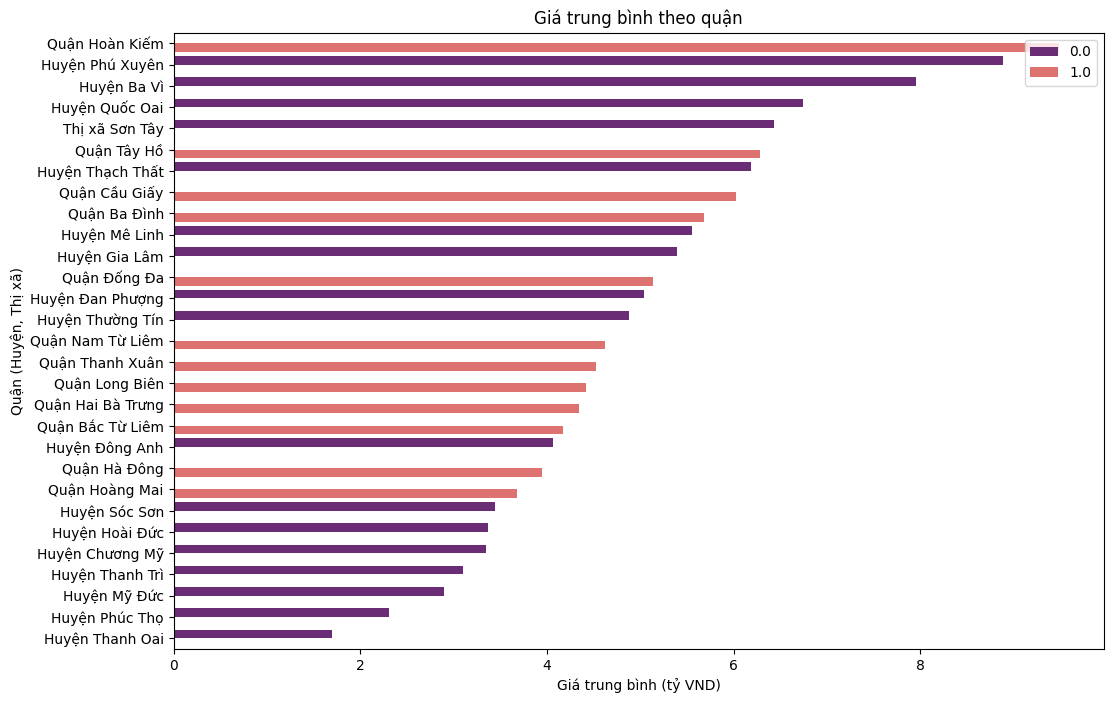

In [81]:
gia_trung_binh_theo_quan = df_drop_outlier.groupby('Quận')[['Giá', 'Nội thành']].mean().sort_values(by=['Giá'], ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(
    x=gia_trung_binh_theo_quan['Giá'].values, y=gia_trung_binh_theo_quan.index,palette='magma',
    order=gia_trung_binh_theo_quan.sort_values(by=['Giá'], ascending=False).index,
    hue=gia_trung_binh_theo_quan['Nội thành'].values
)
plt.xlabel('Giá trung bình (tỷ VND)')
plt.ylabel('Quận (Huyện, Thị xã)')
plt.title('Giá trung bình theo quận')
plt.show()

**Nhận xét**: Có thể thấy giá trung bình 5 quận (huyện) cao nhất có tới 4 huyện ngoại thành.

In [82]:
diff_gia = (
    df_drop_outlier.groupby('Quận')['Giá'].max()
    - df_drop_outlier.groupby('Quận')['Giá'].min()
).sort_values(ascending=False)
diff_gia

Quận
Quận Nam Từ Liêm     31.808110
Quận Hai Bà Trưng    31.799490
Quận Đống Đa         31.701400
Quận Ba Đình         31.599930
Quận Hà Đông         31.399490
Quận Cầu Giấy        31.300120
Huyện Hoài Đức       30.801948
Quận Tây Hồ          30.800460
Quận Long Biên       30.800320
Quận Hoàn Kiếm       30.750360
Quận Thanh Xuân      30.300080
Quận Hoàng Mai       29.800090
Quận Bắc Từ Liêm     28.800680
Huyện Gia Lâm        28.798800
Huyện Đan Phượng     24.550000
Thị xã Sơn Tây       24.347790
Huyện Thường Tín     23.799756
Huyện Ba Vì          23.749908
Huyện Thanh Trì      22.300000
Huyện Mê Linh        18.699700
Huyện Đông Anh       18.649795
Huyện Thạch Thất     15.122430
Huyện Quốc Oai       14.798000
Huyện Sóc Sơn         6.849930
Huyện Chương Mỹ       5.800000
Huyện Thanh Oai       2.700350
Huyện Phúc Thọ        1.375110
Huyện Phú Xuyên       0.000000
Huyện Mỹ Đức          0.000000
Name: Giá, dtype: float64

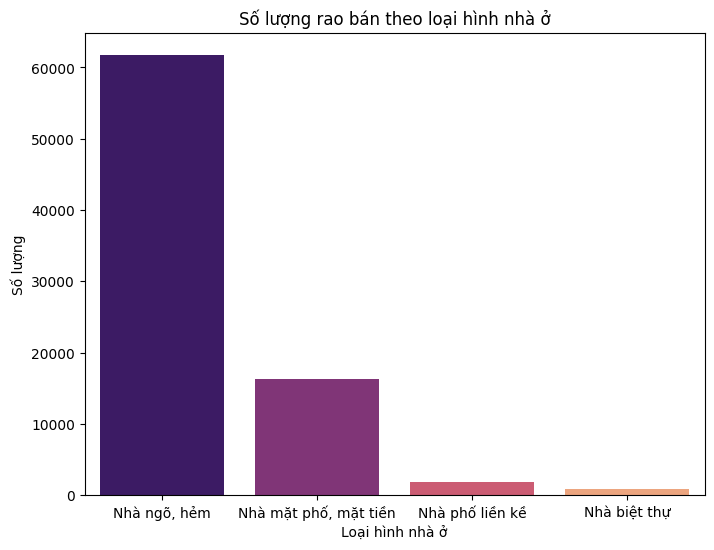

In [83]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_drop_outlier, x='Loại hình nhà ở', palette='magma')
plt.title('Số lượng rao bán theo loại hình nhà ở')
plt.xlabel('Loại hình nhà ở')
plt.ylabel('Số lượng')
plt.show()

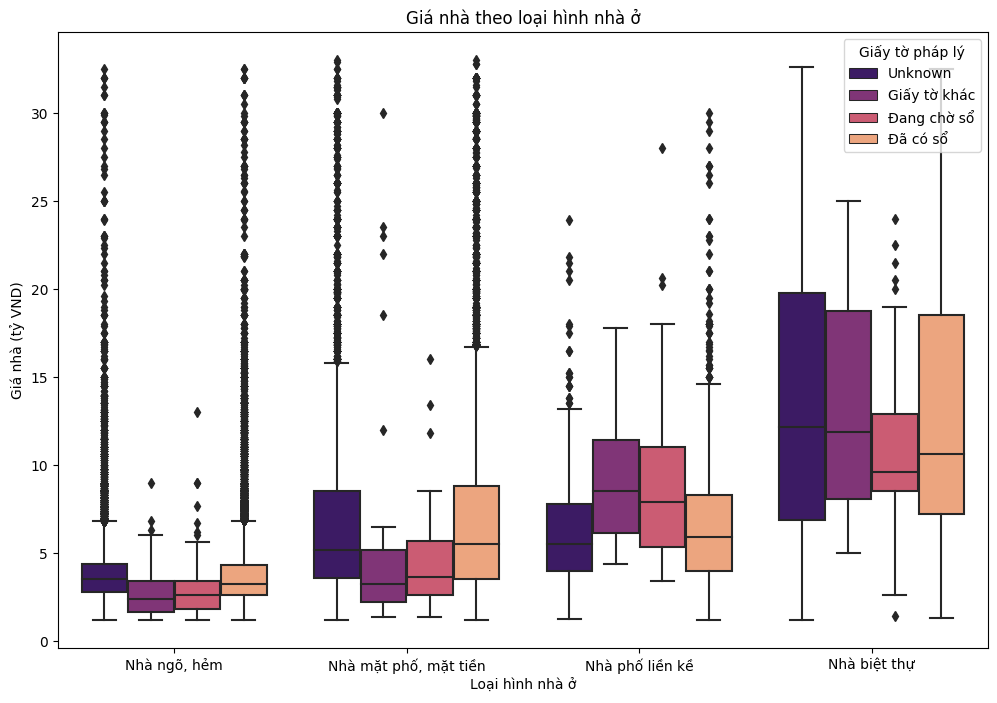

In [84]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_drop_outlier, x='Loại hình nhà ở', y='Giá', palette='magma', hue='Giấy tờ pháp lý')
plt.title('Giá nhà theo loại hình nhà ở')
plt.xlabel('Loại hình nhà ở')
plt.ylabel('Giá nhà (tỷ VND)')
plt.show()

# Xây dựng mô hình dự đoán giá nhà

In [85]:
X = df_drop_outlier.copy()
y = X.pop('Giá')

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
class Classifier:
    
    def __init__(self):
        self.classifiers = {
            'Linear Model': LinearRegression(),
            'Decision Tree': DecisionTreeRegressor(random_state=42),
            'KNN': KNeighborsRegressor(),
            'Ensemble': RandomForestRegressor(random_state=42),
            'XGBoost': XGBRegressor(random_state=42),
        }
        
        self.training_time = {key: 0 for key in self.classifiers.keys()}
        self.training_score = {key: 0 for key in self.classifiers.keys()}
        self.validation_score = {key: 0 for key in self.classifiers.keys()}
    
    def fit(self, X, y):
        print('Training...')
        for classifier in tqdm(self.classifiers):
            t0 = time.time()
            self.classifiers[classifier].fit(X, y)
            t1 = time.time() - t0
            self.training_time[classifier] = round(t1, 2)
            
            # evaluate on training set
            y_pred = self.classifiers[classifier].predict(X)
            self.training_score[classifier] = mean_squared_error(y, y_pred, squared=False)
    
    def score(self, X_test, y_test):
        print('Scoring...')
        for classifier in tqdm(self.classifiers):
            y_pred = self.classifiers[classifier].predict(X_test)
            self.validation_score[classifier] = mean_squared_error(y_test, y_pred, squared=False)
            
    def summary(self):
        return pd.DataFrame({
            'Training Score': self.training_score,
            'Validation Score': self.validation_score,
            'Training Time': self.training_time
        })

## Baseline model

In [88]:
X_train_baseline = X_train.loc[:, ['Diện tích', 'Dài', 'Rộng']]
X_test_baseline = X_test.loc[:, ['Diện tích', 'Dài', 'Rộng']]

In [89]:
baseline_classifier = Classifier()
baseline_classifier.fit(X_train_baseline, y_train)
baseline_classifier.score(X_test_baseline, y_test)

Training...


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Scoring...


100%|██████████| 5/5 [00:00<00:00, 11.52it/s]


In [90]:
baseline_summary = baseline_classifier.summary()
baseline_summary.sort_values(by=['Training Score', 'Validation Score'], ascending=True)

,Training Score,Validation Score,Training Time
Decision Tree,2.485566,3.188828,0.06
Ensemble,2.534372,3.020021,4.55
XGBoost,2.664009,2.958320,1.60
KNN,2.885132,3.120299,0.07
Linear Model,3.627631,3.596869,0.01


## Encode categorical columns

### Ordinal encode

In [91]:
categorical_cols = ['Quận', 'Phường', 'Giấy tờ pháp lý', 'Loại hình nhà ở', 'Số tầng', 'Số phòng ngủ', 'Năm']

X_train_ordinal = X_train.copy()
X_test_ordinal = X_test.copy()
for col in categorical_cols:
    X_train_ordinal[col] = X_train_ordinal[col].cat.codes
    X_test_ordinal[col] = X_test_ordinal[col].cat.codes

X_train_ordinal.drop(['Ngày', 'Địa chỉ', 'Đơn vị tính', 'Giá/m2'], axis=1, inplace=True)
X_test_ordinal.drop(['Ngày', 'Địa chỉ', 'Đơn vị tính', 'Giá/m2'], axis=1, inplace=True)

In [92]:
ordinal_encode_classifier = Classifier()
ordinal_encode_classifier.fit(X_train_ordinal, y_train)
ordinal_encode_classifier.score(X_test_ordinal, y_test)

Training...


100%|██████████| 5/5 [00:31<00:00,  6.38s/it]


Scoring...


100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


In [93]:
ordinal_encode_summary = ordinal_encode_classifier.summary()
ordinal_encode_summary.sort_values(by=['Training Score', 'Validation Score'], ascending=True)

,Training Score,Validation Score,Training Time
Decision Tree,0.564484,3.141049,0.36
Ensemble,0.984751,2.309902,26.53
XGBoost,1.819912,2.224320,0.77
KNN,2.198951,2.766895,0.26
Linear Model,3.118943,3.117197,0.02


### Onehot encode

In [94]:
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

In [95]:
selected_cols = ['Quận', 'Phường', 'Giấy tờ pháp lý', 'Loại hình nhà ở', 'Số tầng', 'Số phòng ngủ', 'Năm']

X_train_oh = X_train.copy()
X_train_oh.reset_index(drop=True, inplace=True)
X_train_oh = pd.concat([X_train_oh, pd.DataFrame(oh_encoder.fit_transform(X_train.loc[:, selected_cols]))], axis=1)
X_train_oh.drop(selected_cols, axis=1, inplace=True)
X_train_oh.drop(['Ngày', 'Địa chỉ', 'Đơn vị tính', 'Giá/m2'], axis=1, inplace=True)
X_train_oh.columns = X_train_oh.columns.astype(str)

X_test_oh = X_test.copy()
X_test_oh.reset_index(drop=True, inplace=True)
X_test_oh = pd.concat([X_test_oh, pd.DataFrame(oh_encoder.transform(X_test.loc[:, selected_cols]))], axis=1)
X_test_oh.drop(selected_cols, axis=1, inplace=True)
X_test_oh.drop(['Ngày', 'Địa chỉ', 'Đơn vị tính', 'Giá/m2'], axis=1, inplace=True)
X_test_oh.columns = X_test_oh.columns.astype(str)

In [96]:
oh_encode_classifier = Classifier()
oh_encode_classifier.fit(X_train_oh, y_train)
oh_encode_classifier.score(X_test_oh, y_test)

Training...


100%|██████████| 5/5 [02:44<00:00, 32.87s/it]


Scoring...


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


In [97]:
oh_encode_summary = oh_encode_classifier.summary()
oh_encode_summary.sort_values(by=['Training Score', 'Validation Score'], ascending=True)

,Training Score,Validation Score,Training Time
Decision Tree,0.564484,2.983355,2.08
Ensemble,0.978234,2.296091,127.97
XGBoost,1.910979,2.254510,9.37
KNN,2.136982,2.707476,0.34
Linear Model,2.797459,2.807987,1.89


### Combine ordinal encoder and onehot encoder

In [98]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64567 entries, 19197 to 16115
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Ngày             64567 non-null  datetime64[ns]
 1   Địa chỉ          64567 non-null  object        
 2   Quận             64567 non-null  category      
 3   Phường           64567 non-null  category      
 4   Loại hình nhà ở  64567 non-null  category      
 5   Giấy tờ pháp lý  64567 non-null  category      
 6   Số tầng          64567 non-null  category      
 7   Số phòng ngủ     64567 non-null  category      
 8   Diện tích        64567 non-null  float64       
 9   Dài              64567 non-null  float64       
 10  Rộng             64567 non-null  float64       
 11  Giá/m2           64567 non-null  float64       
 12  Đơn vị tính      64567 non-null  object        
 13  Nội thành        64567 non-null  bool          
 14  Năm              64567 non-null  catego

In [99]:
print('Số lượng unieque value trong mỗi cột:')
for col in X_train.select_dtypes('category'):
    print(col.ljust(37), len(X_train[col].unique()))

Số lượng unieque value trong mỗi cột:
Quận                                  29
Phường                                285
Loại hình nhà ở                       4
Giấy tờ pháp lý                       4
Số tầng                               12
Số phòng ngủ                          11
Năm                                   2


In [100]:
ordinal_cols = ['Quận', 'Phường', 'Số tầng', 'Số phòng ngủ']
onehot_cols = ['Giấy tờ pháp lý', 'Loại hình nhà ở', 'Năm']

In [101]:
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

In [102]:
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()
for col in ordinal_cols:
    X_train_cb[col] = X_train_cb[col].cat.codes
    X_test_cb[col] = X_test_cb[col].cat.codes

X_train_cb.reset_index(drop=True, inplace=True)
X_test_cb.reset_index(drop=True, inplace=True)

oh_X_train = pd.DataFrame(oh_encoder.fit_transform(X_train_cb.loc[:, onehot_cols]))
X_train_cb = pd.concat([X_train_cb, oh_X_train], axis=1)
X_train_cb.columns = X_train_cb.columns.astype(str)

oh_X_test = pd.DataFrame(oh_encoder.transform(X_test_cb.loc[:, onehot_cols]))
X_test_cb = pd.concat([X_test_cb, oh_X_test], axis=1)
X_test_cb.columns = X_test_cb.columns.astype(str)

X_train_cb.drop(onehot_cols, axis=1, inplace=True)
X_test_cb.drop(onehot_cols, axis=1, inplace=True)

X_train_cb.drop(['Ngày', 'Địa chỉ', 'Đơn vị tính', 'Giá/m2'], axis=1, inplace=True)
X_test_cb.drop(['Ngày', 'Địa chỉ', 'Đơn vị tính', 'Giá/m2'], axis=1, inplace=True)

In [103]:
cb_encode_classifier = Classifier()
cb_encode_classifier.fit(X_train_cb, y_train)
cb_encode_classifier.score(X_test_cb, y_test)

Training...


100%|██████████| 5/5 [00:34<00:00,  6.96s/it]


Scoring...


100%|██████████| 5/5 [00:01<00:00,  4.20it/s]


In [104]:
cb_encode_summary = cb_encode_classifier.summary()
cb_encode_summary.sort_values(by=['Training Score', 'Validation Score'], ascending=True)

,Training Score,Validation Score,Training Time
Decision Tree,0.564484,3.111913,0.41
Ensemble,0.985044,2.307793,28.65
XGBoost,1.803830,2.221658,0.87
KNN,2.168559,2.732875,0.37
Linear Model,3.080040,3.076761,0.03


## Polynormial Feature

In [105]:
poly = PolynomialFeatures(degree=2, include_bias=False)

In [106]:
categorical_cols = ['Quận', 'Phường', 'Giấy tờ pháp lý', 'Loại hình nhà ở', 'Số tầng', 'Số phòng ngủ', 'Năm']

X_train_poly = X_train.copy()
X_test_poly = X_test.copy()
for col in categorical_cols:
    X_train_poly[col] = X_train_poly[col].cat.codes
    X_test_poly[col] = X_test_poly[col].cat.codes

X_train_poly.drop(['Ngày', 'Địa chỉ', 'Đơn vị tính', 'Giá/m2'], axis=1, inplace=True)
X_test_poly.drop(['Ngày', 'Địa chỉ', 'Đơn vị tính', 'Giá/m2'], axis=1, inplace=True)

In [107]:
X_train_poly = poly.fit_transform(X_train_poly)
X_test_poly = poly.transform(X_test_poly)

X_train_poly = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out())
X_test_poly = pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out())

In [108]:
poly_encode_classifier = Classifier()
poly_encode_classifier.fit(X_train_poly, y_train)
poly_encode_classifier.score(X_test_poly, y_test)

Training...


100%|██████████| 5/5 [03:59<00:00, 47.97s/it]


Scoring...


100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


In [109]:
poly_encode_summary = poly_encode_classifier.summary()
poly_encode_summary.sort_values(by=['Training Score', 'Validation Score'], ascending=True)

,Training Score,Validation Score,Training Time
Decision Tree,0.564484,3.144753,3.09
Ensemble,0.986147,2.313448,227.58
XGBoost,1.669352,2.238901,2.46
KNN,2.215169,2.796756,0.01
Linear Model,2.756256,228.841064,0.42


## Select feature

In [110]:
mi_reg = mutual_info_regression(X_train_poly, y_train)

In [111]:
df_mi_reg = pd.DataFrame({
    'Feature': poly.get_feature_names_out(), 'MI': mi_reg
}).sort_values(by=['MI'], ascending=True)

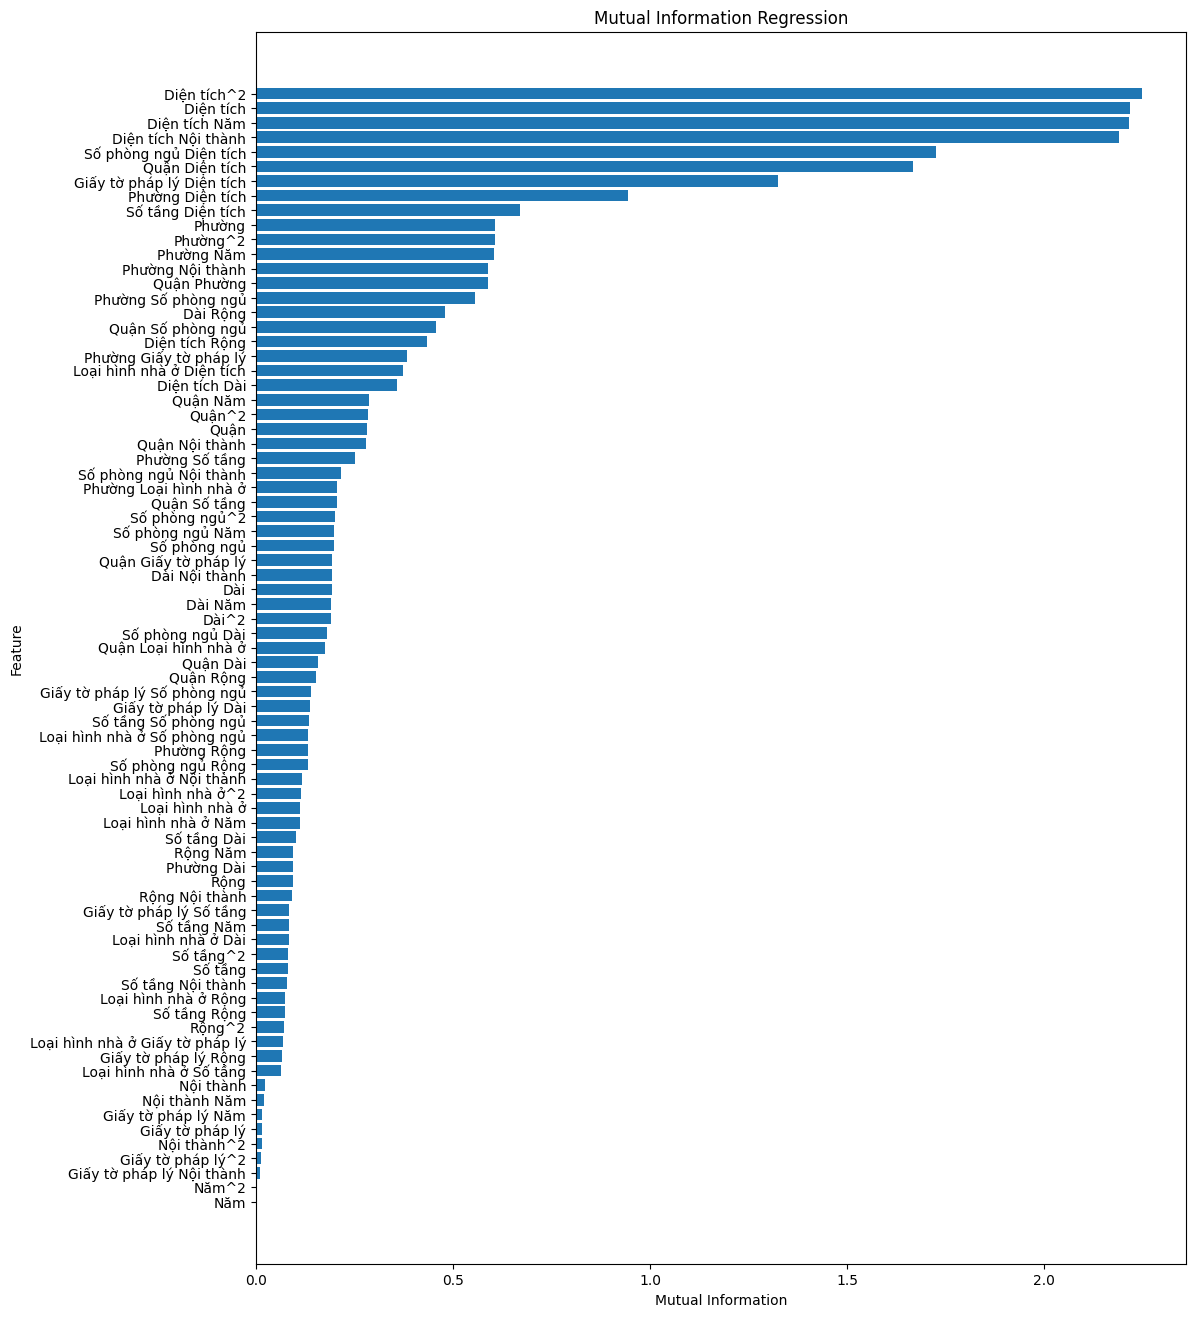

In [112]:
plt.figure(figsize=(12, 16))
plt.barh(y=df_mi_reg['Feature'], width=df_mi_reg['MI'])
plt.title('Mutual Information Regression')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.show()

In [113]:
df_mi_reg[:10]

,Feature,MI
10,Năm,0.000000
76,Năm^2,0.001023
47,Giấy tờ pháp lý Nội thành,0.010839
41,Giấy tờ pháp lý^2,0.013447
74,Nội thành^2,0.014736
3,Giấy tờ pháp lý,0.015884
48,Giấy tờ pháp lý Năm,0.016022
75,Nội thành Năm,0.020922
9,Nội thành,0.022097
34,Loại hình nhà ở Số tầng,0.062741


In [114]:
selected_cols = df_mi_reg.loc[df_mi_reg['MI'] > 0.06, 'Feature'].values

X_train_mi = X_train_poly.loc[:, selected_cols]
X_test_mi = X_test_poly.loc[:, selected_cols]

In [115]:
mi_classifier = Classifier()
mi_classifier.fit(X_train_mi, y_train)
mi_classifier.score(X_test_mi, y_test)

Training...


100%|██████████| 5/5 [03:53<00:00, 46.62s/it]


Scoring...


100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


In [116]:
mi_summary = mi_classifier.summary()
mi_summary.sort_values(by=['Training Score', 'Validation Score'], ascending=True)

,Training Score,Validation Score,Training Time
Decision Tree,0.564484,3.134345,2.89
Ensemble,0.986269,2.311464,221.61
XGBoost,1.672758,2.237032,2.31
KNN,2.215182,2.796796,0.01
Linear Model,2.769495,243.562043,0.33


# Select CatBoost for final model

## Hyperparameter tuning

In [123]:
def objective(trial, X_train=X_train_poly, X_test=X_test_poly, y_train=y_train, y_test=y_test):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 1),
        'n_estimators': trial.suggest_int('n_estimators', 2, 8000),
        'max_depth': trial.suggest_int('max_depth', 0, 20),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 20),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 20),
        'max_delta_step': trial.suggest_float('max_delta_step', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'sampling_method': trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based']),
        'lambda': trial.suggest_float('lambda', 0, 20),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'max_leaves': trial.suggest_int('max_leaves', 0, 20),
        'max_bin': trial.suggest_int('max_bin', 0, 256)
    }

    model = XGBRegressor(**params, random_state=42, n_jobs=-1, tree_method='gpu_hist', eval_metric='rmse')
    model.fit(X_train, y_train, early_stopping_rounds=300, eval_set=[(X_test, y_test)], verbose=False)
    
    y_pred = model.predict(X_test)
    test_score = mean_squared_error(y_test, y_pred, squared=False)
    return test_score

In [124]:
import optuna

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-07-04 15:42:19,386] A new study created in memory with name: no-name-be53c5ba-fb1f-4308-9e6b-5c1d011497a4
[I 2023-07-04 15:42:22,320] Trial 0 finished with value: 2.4581241996905905 and parameters: {'learning_rate': 0.9351256655351988, 'n_estimators': 562, 'max_depth': 10, 'min_split_loss': 9.963133505787305, 'min_child_weight': 6.983525815341112, 'max_delta_step': 4.164745268777517, 'subsample': 0.5174244864660726, 'sampling_method': 'uniform', 'lambda': 4.674191675760357, 'grow_policy': 'lossguide', 'max_leaves': 15, 'max_bin': 190}. Best is trial 0 with value: 2.4581241996905905.
[I 2023-07-04 15:42:25,833] Trial 1 finished with value: 2.3089297801329036 and parameters: {'learning_rate': 0.8041246894120219, 'n_estimators': 4597, 'max_depth': 8, 'min_split_loss': 18.792352249326832, 'min_child_weight': 14.817592913714714, 'max_delta_step': 7.586595862440545, 'subsample': 0.7091815994999221, 'sampling_method': 'uniform', 'lambda': 16.84501187910452, 'grow_policy': 'lossguide',

Number of finished trials: 200
Best trial: {'learning_rate': 0.04973602396070805, 'n_estimators': 7940, 'max_depth': 19, 'min_split_loss': 1.3727347013065085, 'min_child_weight': 10.528460684696194, 'max_delta_step': 3.267535676781958, 'subsample': 0.6176051518547742, 'sampling_method': 'gradient_based', 'lambda': 4.271217967428994, 'grow_policy': 'lossguide', 'max_leaves': 19, 'max_bin': 233}


In [125]:
params = study.best_trial.params

In [128]:
model = XGBRegressor(**params, random_state=42, n_jobs=-1, tree_method='gpu_hist', eval_metric='rmse')
model.fit(X_train_poly, y_train, early_stopping_rounds=300, eval_set=[(X_test_poly, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy='lossguide',
             importance_type=None, interaction_constraints=None,
             lambda=4.271217967428994, learning_rate=0.04973602396070805,
             max_bin=233, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=3.267535676781958, max_depth=19, max_leaves=19,
             min_child_weight=10.528460684696194,
             min_split_loss=1.3727347013065085, missing=nan,
             monotone_constraints=None, n_estimators=7940, n_jobs=-1,
             num_parallel_tree=None, ...)

In [129]:
y_train_pred = model.predict(X_train_poly)
print('Training RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))

Training RMSE: 1.5588446682861739


In [130]:
y_pred = model.predict(X_test_poly)
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

RMSE: 2.177325929910551


# Summary

In [142]:
df_pred = pd.DataFrame({
    'y_pred': y_pred,
    'y_test': y_test,
    'error': y_pred - y_test
})

In [143]:
df_pred.head()

,y_pred,y_test,error
66342,4.740809,3.50013,1.240679
37974,3.023847,2.80005,0.223797
11653,5.803710,5.49990,0.303810
61887,3.826113,3.79988,0.026233
34579,2.597617,2.20000,0.397617


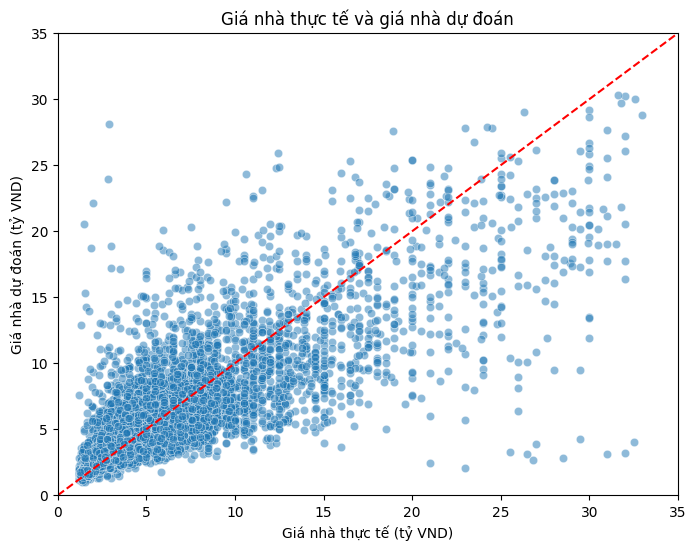

In [147]:
lim = (0, 35)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pred, x='y_test', y='y_pred', alpha=0.5)
plt.xlim(*lim)
plt.ylim(*lim)
plt.plot(lim, lim, color='red', linestyle='--')
plt.title('Giá nhà thực tế và giá nhà dự đoán')
plt.xlabel('Giá nhà thực tế (tỷ VND)')
plt.ylabel('Giá nhà dự đoán (tỷ VND)')
plt.show()

In [148]:
df_pred['error'].max()

25.191873060302733

In [149]:
max_error = df_pred['error'].abs().max()
print('Error cao nhất:', max_error, 'tỷ')
max_errpr_idx = df_pred[df_pred['error'].abs() == max_error].index
df.loc[max_errpr_idx]

Error cao nhất: 28.81909680366516 tỷ


,Ngày,Địa chỉ,Quận,Phường,Loại hình nhà ở,Giấy tờ pháp lý,Số tầng,Số phòng ngủ,Diện tích,Dài,Rộng,Giá/m2,Đơn vị tính,Giá,Nội thành,Năm
59658,2020-06-24,"Đường Thanh Nhàn, Phường Thanh Nhàn, Quận Hai ...",Quận Hai Bà Trưng,Phường Thanh Nhàn,"Nhà ngõ, hẻm",Đã có sổ,5,5 phòng,32.0,8.0,4.0,1.0,tỷ/m²,32.0,True,2020


In [150]:
min_error = df_pred['error'].abs().min()
print('Error thấp nhất:', min_error, 'tỷ')
min_errpr_idx = df_pred[df_pred['error'].abs() == min_error].index
df.loc[min_errpr_idx]

Error thấp nhất: 0.00018965110778790262 tỷ


,Ngày,Địa chỉ,Quận,Phường,Loại hình nhà ở,Giấy tờ pháp lý,Số tầng,Số phòng ngủ,Diện tích,Dài,Rộng,Giá/m2,Đơn vị tính,Giá,Nội thành,Năm
76713,2020-06-10,"Đường Hà Trì 2, Phường Hà Cầu, Quận Hà Đông, H...",Quận Hà Đông,Phường Hà Cầu,"Nhà ngõ, hẻm",Đã có sổ,Unknown,3 phòng,35.0,0.0,0.0,74.29,triệu/m²,2.60015,True,2020


In [151]:
!jupyter nbconvert --to html hanoi_fix.ipynb

[NbConvertApp] Converting notebook hanoi_fix.ipynb to html
[NbConvertApp] Writing 1846009 bytes to hanoi_fix.html
